In [39]:
library(Seurat)
library(ArchR)
library(cowplot)

In [5]:
gsm_se <- getMatrixFromArrow("../data/3k_sorted.arrow", 'GeneScoreMatrix')

ArchR logging to : ArchRLogs/ArchR-getMatrixFromArrow-ab109c6e-Date-2020-11-30_Time-16-55-38.log
If there is an issue, please report to github with logFile!

2020-11-30 16:55:38 : Getting GeneScoreMatrix from ArrowFile : 3k_sorted.arrow, 0.003 mins elapsed.

2020-11-30 16:55:43 : Organizing SE GeneScoreMatrix from ArrowFile : 3k_sorted.arrow, 0.082 mins elapsed.



In [32]:
ARROWFILE <- "../data/3k_sorted.arrow"
SEURATOBJ <- "../data/3k_sorted_seurat.rds"

In [26]:
gsm_se    <- getMatrixFromArrow(ARROWFILE, 'GeneScoreMatrix')
gsm       <- assays(gsm_se)[['GeneScoreMatrix']]
row_data  <- rowData(gsm_se)
genes     <- row_data["name"]
gsm_df    <- as.data.frame(as.matrix(gsm))
gsm_df    <- sapply(gsm_df + 0.5, as.integer) # round to nearest integer.
row.names(gsm_df) <- genes$name
colnames(gsm_df)  <- substring(colnames(gsm_df), 11, 30)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromArrow-a7b4098b6-Date-2020-11-30_Time-17-07-07.log
If there is an issue, please report to github with logFile!

2020-11-30 17:07:07 : Getting GeneScoreMatrix from ArrowFile : 3k_sorted.arrow, 0.002 mins elapsed.

2020-11-30 17:07:11 : Organizing SE GeneScoreMatrix from ArrowFile : 3k_sorted.arrow, 0.08 mins elapsed.



In [29]:
head(gsm_df)

,TGAGCACGTCCTTCTC-1,ACTTGAATCAGCTAAC-1,CAGCATGTCTACCTAT-1,TAAGGCTTCAGGGCCT-1,TGTGGCCAGCGAGTAA-1,CATAACGGTTGCAATG-1,AAGTGTTGTGAGACTC-1,ACGAATCTCGGGCCAT-1,GGCTAGTGTACGCGCA-1,GACACCGGTGGGTACT-1,⋯,TGCGGTTCAATTAACC-1,TAGCCTGAGGGCCACT-1,AATTGCTCATCGTTCT-1,AGCGGACCAAGACTCC-1,CACCAACCAATTGCGC-1,CTAATCGCAAGACTCC-1,TAAGCTATCCCTGATC-1,TCATGAGGTTCATTTG-1,GGTTGCGGTGACCTGG-1,GGTAGGAGTCACTCGC-1
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC729737,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC101928626,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LINC01128,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,7,0,0,0,0,0
LINC00115,0,0,0,0,1,0,0,1,1,0,⋯,0,0,0,0,19,0,0,0,0,0


In [44]:
predictedSeurat <- CreateSeuratObject(
  gsm_df,
  project = "SeuratProject",
  assay = "pRNA",
  min.cells = 0,
  min.features = 0,
  names.field = 1,
  names.delim = "_",
  meta.data = NULL
)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [45]:
expressionSeurat <- readRDS(file = SEURATOBJ)

In [46]:
immune.anchors <- FindIntegrationAnchors(object.list = c(predictedSeurat, expressionSeurat), dims = 1:20)

Warning message in CheckDuplicateCellNames(object.list = object.list):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Computing 2000 integration features

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6681 anchors

Filtering anchors

	Retained 3386 anchors



In [47]:
immune.combined <- IntegrateData(anchorset = immune.anchors, dims = 1:20)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"


In [48]:
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
# t-SNE and Clustering
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

17:18:18 UMAP embedding parameters a = 0.9922 b = 1.112

17:18:18 Read 5398 rows and found 20 numeric columns

17:18:18 Using Annoy for neighbor search, n_neighbors = 30

17:18:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:18:19 Writing NN index file to temp file /tmp/RtmpaHaxvW/filea71a04d19

17:18:19 Searching Annoy index using 1 thread, search_k = 3000

17:18:20 Annoy recall = 100%

17:18:21 Commencing smooth kNN distance calibration using 1 thread

17:18:22 Initializing from normalized Laplacian + noise

17:18:22 Commencing optimization for 500 epochs, with 246926 positive edges

17:18:28 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5398
Number of edges: 258784

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9048
Number of communities: 13
Elapsed time: 0 seconds


In [52]:
immune.combined

An object of class Seurat 
360143 features across 5398 samples within 6 assays 
Active assay: integrated (2000 features, 2000 variable features)
 5 other assays present: pRNA, RNA, ATAC, ATAC_distal, ATAC_promoter
 2 dimensional reductions calculated: pca, umap

In [53]:
options(repr.plot.width = 14, repr.plot.height = 7)
# Visualization
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "assay")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE)
plot_grid(p1, p2)


ERROR: Error: Cannot find 'assay' in this Seurat object


In [54]:
library(tidyverse)

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

── Attaching packages ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ───────────
✖ dplyr::between()         masks data.table::between()
✖ dplyr::collapse()        masks IRanges::collapse()
✖ dplyr::combine()         masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()           masks matrixStats::count()
✖ dplyr::desc()            masks IRanges::desc()
✖ tidyr::expand()          masks Matrix::expand(), S4Vectors::expand()
✖ tidyr::extract()         masks magrittr::extract()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::first()           masks data.table::first(), S4Vectors::first()
✖ dplyr::lag()             masks stats::lag()
✖ dplyr::last()            masks data.table::last()
✖ tidyr::pack()            masks Matrix::pack()
✖ BiocGenerics::Position() masks ggplot2::Position(

In [60]:
umap_tx = immune.combined@reductions$umap@cell.embeddings  %>% as.data.frame() %>% cbind(tx = immune.combined@meta.data$orig.ident)


In [64]:
umap_tx

,UMAP_1,UMAP_2,tx
,<dbl>,<dbl>,<chr>
TGAGCACGTCCTTCTC-1_1,7.566568,5.5271936,SeuratProject
ACTTGAATCAGCTAAC-1_1,7.542544,5.5210133,SeuratProject
CAGCATGTCTACCTAT-1_1,7.466366,5.5381489,SeuratProject
TAAGGCTTCAGGGCCT-1_1,7.651087,5.3429523,SeuratProject
TGTGGCCAGCGAGTAA-1_1,-6.558474,-3.6579987,SeuratProject
CATAACGGTTGCAATG-1_1,7.573347,5.4313985,SeuratProject
AAGTGTTGTGAGACTC-1_1,7.785913,4.6288834,SeuratProject
ACGAATCTCGGGCCAT-1_1,7.574651,5.3886471,SeuratProject
GGCTAGTGTACGCGCA-1_1,7.857079,3.2104784,SeuratProject


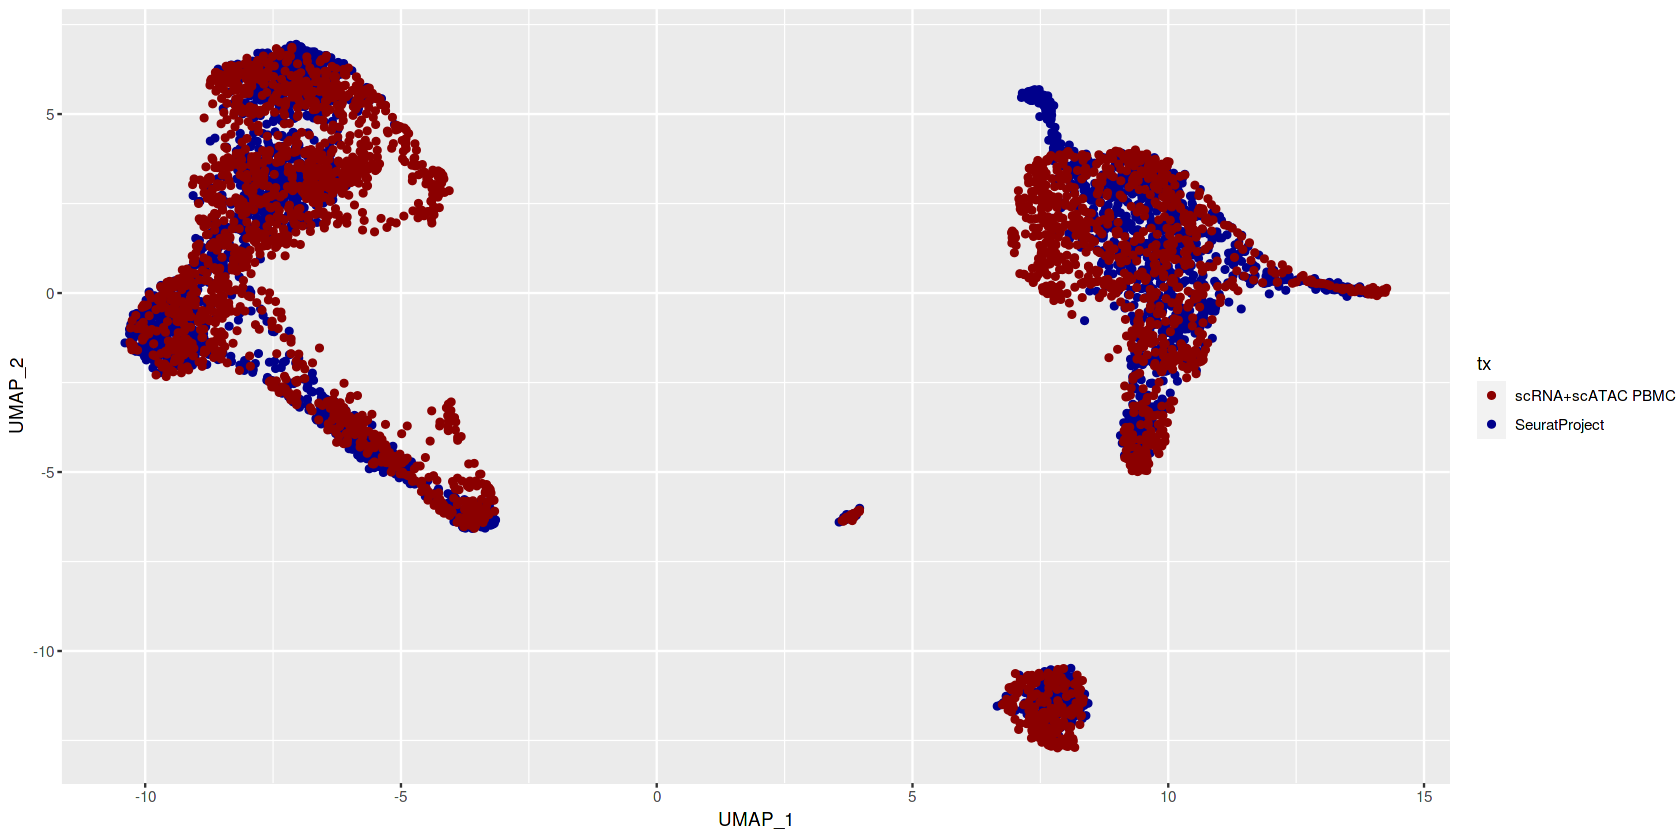

In [65]:
ggplot(umap_tx, aes(x=UMAP_1, y=UMAP_2, color=tx)) + geom_point() + scale_color_manual(values=c("SeuratProject" = "darkblue", 
                            "scRNA+scATAC PBMC" = "darkred"))